In [1]:
from skimage import io, color, exposure, transform
from keras.layers import Dense
import numpy as np
from keras.models import Sequential
import matplotlib.pyplot as plt
import os
import glob

Using TensorFlow backend.


In [75]:
# %load preprocess_images.py

# Pre-process the images and add the labels for them
IMG_SIZE = 32
NUM_CLASSES=62
ROOT_PATH = 'C:/Users/cristian.schuszter/Desktop'

root_training_dir = ROOT_PATH + '/Traffic sign recognition dataset/Training'
root_testing_dir = ROOT_PATH + '/Traffic sign recognition dataset/Testing'

def preprocess_image(img):
    """
    Take an image from the initial ppm dataset and then preprocess it so that it looks good.
    Then, resize to some standard shape provided above
    """
    hsv = color.rgb2hsv(img)
    hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
    img = color.hsv2rgb(hsv)
    
    min_side = min(img.shape[:-1])
    centre = img.shape[0] // 2, img.shape[1] // 2
    img = img[centre[0] - min_side // 2 : centre[0] + min_side // 2,
             centre[1] - min_side // 2 : centre[1] + min_side // 2]
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE), mode = 'reflect')
    #img = np.rollaxis(img, -1)
    return img


def get_class(path):
    cls = int(path.split('\\')[-2])
    return cls

def get_tsr_train_data():
    all_image_paths = glob.glob(os.path.join(root_training_dir, '*/*.ppm'))
    imgs = []
    labels = []
    count = 0
    np.random.shuffle(all_image_paths)
    for img_path in all_image_paths:
        img = preprocess_image(io.imread(img_path))
        label = get_class(img_path)
        labels.append(label)
        if count % 20 == 0:
            print('{:.2f}% of all training images processed'.format((count / len(all_image_paths) * 100)))
        count+=1
        imgs.append(img)
    print ('Done processing training images!')
    return imgs, labels
    

def get_tsr_test_data():
    all_image_paths = glob.glob(os.path.join(root_testing_dir, '*/*.ppm'))
    imgs = []
    labels = []
    count = 0
    np.random.shuffle(all_image_paths)
    for img_path in all_image_paths:
        img = preprocess_image(io.imread(img_path))
        label = get_class(img_path)
        labels.append(label)
        if count % 20 == 0:
            print('{:.2f}% of all testing images processed'.format((count / len(all_image_paths) * 100)))
        count+=1
        imgs.append(img)
    print ('Done processing test images!')
    return imgs, labels

In [76]:
imgs, labels = get_tsr_train_data()

0.00% of all training images processed
0.44% of all training images processed
0.87% of all training images processed
1.31% of all training images processed
1.75% of all training images processed
2.19% of all training images processed
2.62% of all training images processed
3.06% of all training images processed
3.50% of all training images processed
3.93% of all training images processed
4.37% of all training images processed
4.81% of all training images processed
5.25% of all training images processed
5.68% of all training images processed
6.12% of all training images processed
6.56% of all training images processed
6.99% of all training images processed
7.43% of all training images processed
7.87% of all training images processed
8.31% of all training images processed
8.74% of all training images processed
9.18% of all training images processed
9.62% of all training images processed
10.05% of all training images processed
10.49% of all training images processed
10.93% of all training 

90.05% of all training images processed
90.49% of all training images processed
90.93% of all training images processed
91.37% of all training images processed
91.80% of all training images processed
92.24% of all training images processed
92.68% of all training images processed
93.11% of all training images processed
93.55% of all training images processed
93.99% of all training images processed
94.43% of all training images processed
94.86% of all training images processed
95.30% of all training images processed
95.74% of all training images processed
96.17% of all training images processed
96.61% of all training images processed
97.05% of all training images processed
97.49% of all training images processed
97.92% of all training images processed
98.36% of all training images processed
98.80% of all training images processed
99.23% of all training images processed
99.67% of all training images processed
Done processing training images!


In [77]:
test_imgs, test_y = get_tsr_test_data()

0.00% of all testing images processed
0.79% of all testing images processed
1.59% of all testing images processed
2.38% of all testing images processed
3.17% of all testing images processed
3.97% of all testing images processed
4.76% of all testing images processed
5.56% of all testing images processed
6.35% of all testing images processed
7.14% of all testing images processed
7.94% of all testing images processed
8.73% of all testing images processed
9.52% of all testing images processed
10.32% of all testing images processed
11.11% of all testing images processed
11.90% of all testing images processed
12.70% of all testing images processed
13.49% of all testing images processed
14.29% of all testing images processed
15.08% of all testing images processed
15.87% of all testing images processed
16.67% of all testing images processed
17.46% of all testing images processed
18.25% of all testing images processed
19.05% of all testing images processed
19.84% of all testing images processed

In [5]:
len(test_imgs)

2520

C:\Users\cristian.schuszter\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


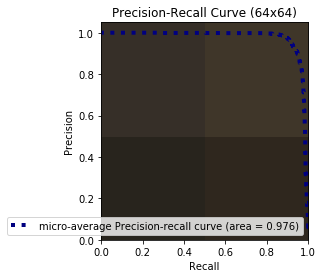

In [78]:
plt.imshow(imgs[0])
io.imsave(ROOT_PATH + '/outsign.png', imgs[0])
plt.show()

## After processing, start applying machine learning algos

We'll be using the bag of words model applied for image classification by extracting some meaningful features from each image and then creating the so-called histogram representing each of the input images.

### Step 1: Create a K-means classifier out of image features / extract HOG features and compute SVM directly

C:\Users\cristian.schuszter\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


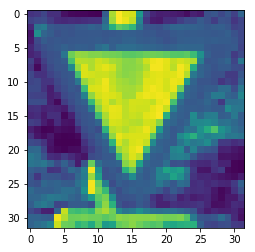

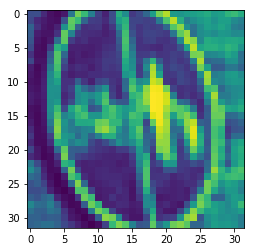

In [79]:
grayimg = color.rgb2grey(imgs[0])
plt.imshow(grayimg)
io.imsave(ROOT_PATH + '/outsign_gray.png', grayimg)
plt.show()

grayimg = color.rgb2grey(test_imgs[0])
plt.imshow(grayimg)
plt.show()

In [80]:
from skimage.feature import hog
from skimage import color
import numpy as np

def get_hog_descriptors(imgs):
    count = 0
    descriptor_len = None
    training_set = np.array([])
    for i in range(0, len(imgs)):
        grayimg = color.rgb2grey(imgs[i])
        hog_descriptors = np.array(hog(grayimg, block_norm='L2-Hys'))
        training_set = np.concatenate((training_set,hog_descriptors))
        if descriptor_len is None:
            descriptor_len = len(hog_descriptors)
        if count % 20 == 0:
            print('{:.2f}% of all images hog descriptors computed'.format((count / len(imgs) * 100)))
        count+=1
    return np.reshape(training_set, (len(imgs), descriptor_len))

def get_hog_descriptor_and_image(img):
    grayimg = color.rgb2grey(imgs[i])
    (hog_descriptors, image) = hog(grayimg, visualise=True)
    return (np.array(hog_descriptors), np.array(image))

In [81]:
train_x = get_hog_descriptors(imgs)

0.00% of all images hog descriptors computed
0.44% of all images hog descriptors computed
0.87% of all images hog descriptors computed
1.31% of all images hog descriptors computed
1.75% of all images hog descriptors computed
2.19% of all images hog descriptors computed
2.62% of all images hog descriptors computed
3.06% of all images hog descriptors computed
3.50% of all images hog descriptors computed
3.93% of all images hog descriptors computed
4.37% of all images hog descriptors computed
4.81% of all images hog descriptors computed
5.25% of all images hog descriptors computed
5.68% of all images hog descriptors computed
6.12% of all images hog descriptors computed
6.56% of all images hog descriptors computed
6.99% of all images hog descriptors computed
7.43% of all images hog descriptors computed
7.87% of all images hog descriptors computed
8.31% of all images hog descriptors computed
8.74% of all images hog descriptors computed
9.18% of all images hog descriptors computed
9.62% of a

78.69% of all images hog descriptors computed
79.13% of all images hog descriptors computed
79.56% of all images hog descriptors computed
80.00% of all images hog descriptors computed
80.44% of all images hog descriptors computed
80.87% of all images hog descriptors computed
81.31% of all images hog descriptors computed
81.75% of all images hog descriptors computed
82.19% of all images hog descriptors computed
82.62% of all images hog descriptors computed
83.06% of all images hog descriptors computed
83.50% of all images hog descriptors computed
83.93% of all images hog descriptors computed
84.37% of all images hog descriptors computed
84.81% of all images hog descriptors computed
85.25% of all images hog descriptors computed
85.68% of all images hog descriptors computed
86.12% of all images hog descriptors computed
86.56% of all images hog descriptors computed
86.99% of all images hog descriptors computed
87.43% of all images hog descriptors computed
87.87% of all images hog descripto

In [82]:
test_x = get_hog_descriptors(test_imgs)

0.00% of all images hog descriptors computed
0.79% of all images hog descriptors computed
1.59% of all images hog descriptors computed
2.38% of all images hog descriptors computed
3.17% of all images hog descriptors computed
3.97% of all images hog descriptors computed
4.76% of all images hog descriptors computed
5.56% of all images hog descriptors computed
6.35% of all images hog descriptors computed
7.14% of all images hog descriptors computed
7.94% of all images hog descriptors computed
8.73% of all images hog descriptors computed
9.52% of all images hog descriptors computed
10.32% of all images hog descriptors computed
11.11% of all images hog descriptors computed
11.90% of all images hog descriptors computed
12.70% of all images hog descriptors computed
13.49% of all images hog descriptors computed
14.29% of all images hog descriptors computed
15.08% of all images hog descriptors computed
15.87% of all images hog descriptors computed
16.67% of all images hog descriptors computed
1

C:\Users\cristian.schuszter\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


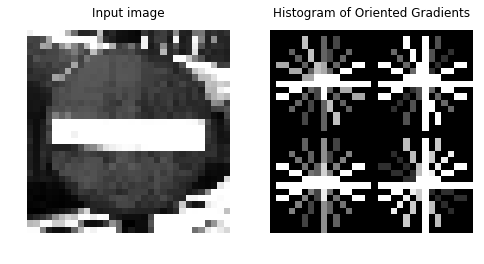

In [83]:
# Display hog descriptors of an image
from skimage.feature import hog
from skimage import data, color, exposure
def plot_hog_image(index):
    plt.close()

    image = color.rgb2gray(imgs[index])

    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1), visualise=True)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

    ax1.axis('off')
    ax1.imshow(image, cmap=plt.cm.gray)
    ax1.set_title('Input image')
    ax1.set_adjustable('box-forced')

    # Rescale histogram for better display
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

    ax2.axis('off')
    ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
    ax2.set_title('Histogram of Oriented Gradients')
    ax1.set_adjustable('box-forced')
    plt.savefig(ROOT_PATH + '/hog-visualization.png')
    plt.show()

plot_hog_image(1155)

### Step 2: Compute SVC classifier given the training input

In [84]:
labels_back = labels
test_y_back = test_y

In [85]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import fbeta_score, make_scorer

In [86]:

clf = SVC(probability=True)
clf.fit(train_x, labels)
#scores = cross_val_score(clf, train_x,labels, scoring='accuracy')
#classification_score = clf.score(test_x, test_y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [ ]:
from sklearn.externals import joblib
joblib.dump(clf, 'svm_hog.pkl') 

In [ ]:
print('Accuracy: {}'.format(classification_score))
print('Confidence in accuracy: {} (+- {})'.format(scores.mean(), scores.std()))

In [ ]:
predict_y = clf.predict(test_x)

### Step 3: Pretty graphs

In [87]:
from scikitplot.classifiers import plot_precision_recall_curve

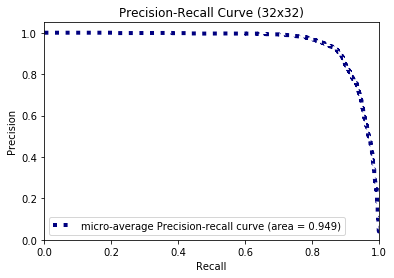

In [88]:
roc_curve = plot_precision_recall_curve(clf, test_x, test_y, curves=('micro'), 
                                        title='Precision-Recall Curve ({}x{})'.format(IMG_SIZE, IMG_SIZE))
plt.savefig(ROOT_PATH + '/precision-recall-{}.png'.format(IMG_SIZE))
plt.show()